# RNN in PyTorch
> Recurrent Neural Networks in PyTorch

- badges: true
- comments: true
- author: Naman Manchanda
- categories: [rnn, jupyter, pytorch, python]

<h1><center>Recurrent Neural Network in PyTorch</center></h1>

Table of Contents: <a id=100></a>

1. [Packages](#1)
2. [Data definition](#2)
    - 2.1 [Declaring a tensor `x`](#3)
    - 2.2 [Creating a tensor `y` as a sin function of `x`](#4)
    - 2.3 [Plotting `y`](#5)
3. [Batching the data](#6)
    - 3.1 [Splitting the data in train/test set](#7)
    - 3.2 [Creating the batches of data](#8)
4. [Defining the model](#9)
    - 4.1 [Model class](#10)
    - 4.2 [Model instantiation](#11)
    - 4.3 [Training](#12)
5. [Alcohol Sales dataset](#13)
    - 5.1 [Loading and plotting](#14)
    - 5.2 [Prepare and normalize](#15)
    - 5.3 [Modelling](#16)
    - 5.4 [Predictions](#17)

Recurrent Neural Networks are a type of neural networks that are designed to work on sequence prediction models. RNNs can be used for text data, speech data, classification problems and generative models. Unlike ANNs, RNNs' prediction are based on the past prediction as well as the current input. RNNs are networks with loops in them allowing information to persist.

Each node of an **RNN** consists of 2 inputs:
1. Memory unit
2. Event unit

`M(t-1)` is the memory unit or the output of the previous prediction. `E(t)` is the current event or the information being provided at the present time. `M(t)` is the output of the current node or the output at the present time in the sequence.

### 1. Packages <a id=1></a>
[back to top](#100)

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Data definition <a id=2></a>
[back to top](#100)

In this notebook, I'm going to train a very simple LSTM model, which is a type of RNN architecture to do time series prediction. Given some input data, it should be able to generate a prediction for the next step. I'll be using a **Sin** wave as an example as it's very easy to visualiase the behaviour of a sin wave.


#### 2.1 Declaring a tensor `x` <a id=3></a>

In [2]:
x = torch.linspace(0,799,800)

#### 2.2 Creating a tensor `y` as a sin function of `x` <a id=4></a>

In [3]:
y = torch.sin(x*2*3.1416/40)

#### 2.3 Plotting `y` <a id=5></a>

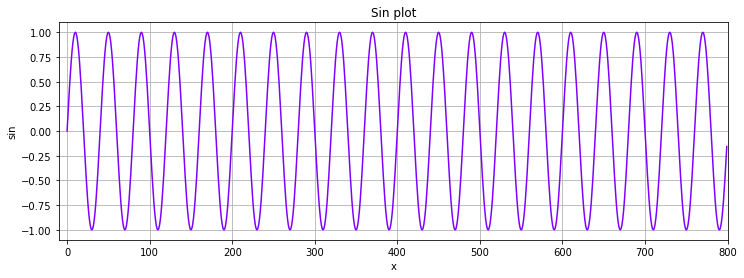

In [4]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("sin")
plt.title("Sin plot")
plt.plot(y.numpy(),color='#8000ff')
plt.show()

### 3. Batching the data <a id=6></a>
[back to top](#100)

#### 3.1 Splitting the data in train/test set <a id=7></a>

In [5]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

##### 3.1.1 Plotting the training/testing set

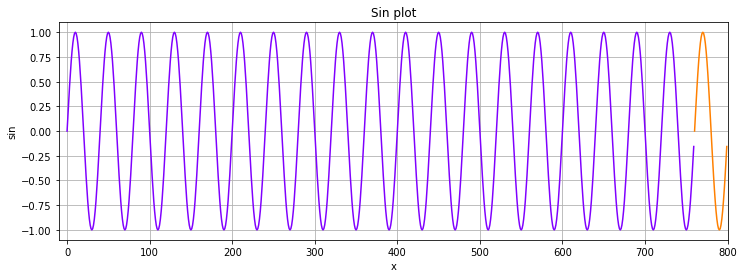

In [6]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("sin")
plt.title("Sin plot")
plt.plot(train_set.numpy(),color='#8000ff')
plt.plot(range(760,800),test_set.numpy(),color="#ff8000")
plt.show()

#### 3.2 Creating the batches of data <a id=8></a>

While working with LSTM models, we divide the training sequence into series of overlapping windows. The label used for comparison is the next value in the sequence.

For example if we have series of of 12 records and a window size of 3, we feed [x1, x2, x3] into the model, and compare the prediction to `x4`. Then we backdrop, update parameters, and feed [x2, x3, x4] into the model and compare the prediction to `x5`. To ease this process, I'm defining a function `input_data(seq,ws)` that created a list of (seq,labels) tuples. If `ws` is the window size, then the total number of (seq,labels) tuples will be `len(series)-ws`.

In [7]:
def input_data(seq,ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    
    return out

##### 3.2.1 Calling the `input_data` function
The length of `x` = 800

The length of `train_set` = 800 - 40 = 760

The length of `train_data` = 760 - 40 - 720

In [8]:
window_size = 40
train_data = input_data(train_set, window_size)
len(train_data)

720

##### 3.2.2 Checking the 1st value from train_data

In [9]:
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

### 4. Defining the model <a id=9></a>
[back to top](#100)

#### 4.1 Model Class <a id=10></a>

In [10]:
class LSTM(nn.Module):
    
    def __init__(self,input_size = 1, hidden_size = 50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

#### 4.2 Model Instantiation <a id = 11></a>

In [11]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

##### 4.2.1 Printing the model

In [12]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

#### 4.3 Training <a id = 12></a>

During training, I'm visualising the prediction process for the test data on the go. It will give a better understanding of how the training is being carried out in each epoch. The training sequence is represented in <span style="color:#8000ff">purple</span> while the predicted sequence in represented in <span style="color:#ff8000">orange</span>.

Epoch 0 Loss: 0.09212876856327057
Performance on test range: 0.6071590185165405


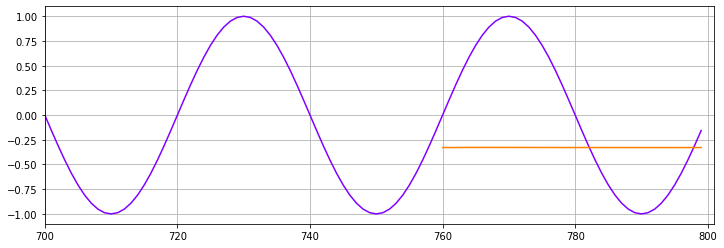

Epoch 1 Loss: 0.06506767123937607
Performance on test range: 0.5650987029075623


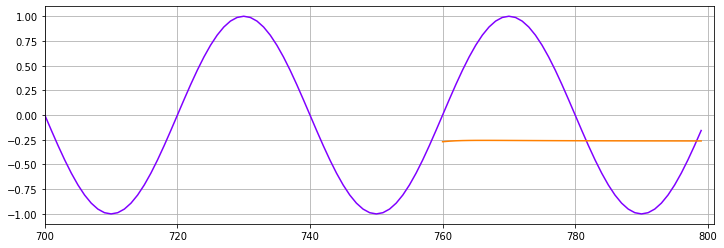

Epoch 2 Loss: 0.041980478912591934
Performance on test range: 0.5199716687202454


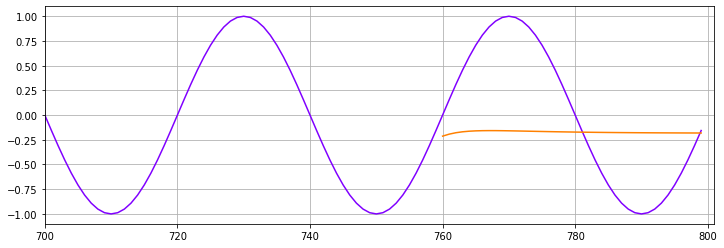

Epoch 3 Loss: 0.017842764034867287
Performance on test range: 0.42209967970848083


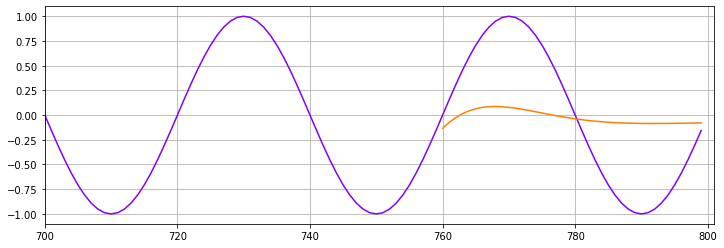

Epoch 4 Loss: 0.0028870997484773397
Performance on test range: 0.16624125838279724


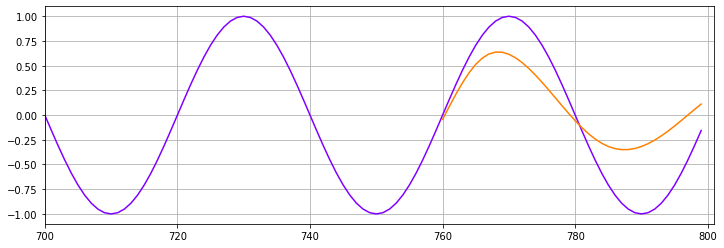

Epoch 5 Loss: 0.00032007633126340806
Performance on test range: 0.030554424971342087


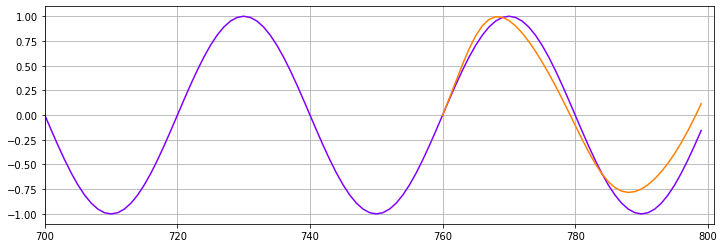

Epoch 6 Loss: 0.00012969240196980536
Performance on test range: 0.014990185387432575


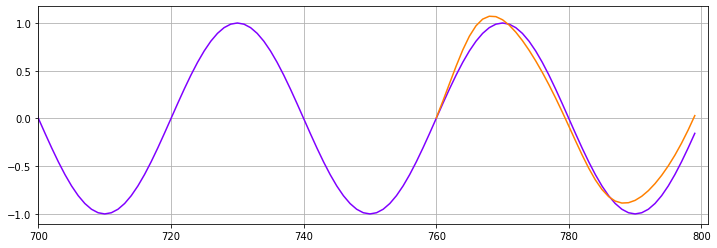

Epoch 7 Loss: 0.00012006766337435693
Performance on test range: 0.01185668632388115


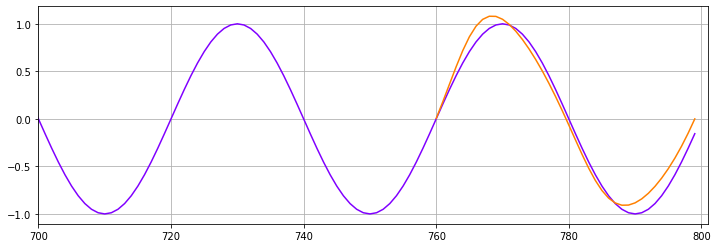

Epoch 8 Loss: 0.0001265572354895994
Performance on test range: 0.010163827799260616


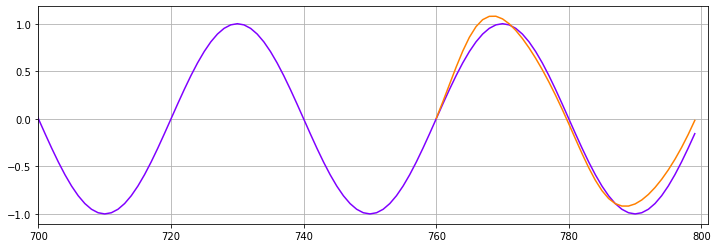

Epoch 9 Loss: 0.0001319547591265291
Performance on test range: 0.008897590450942516


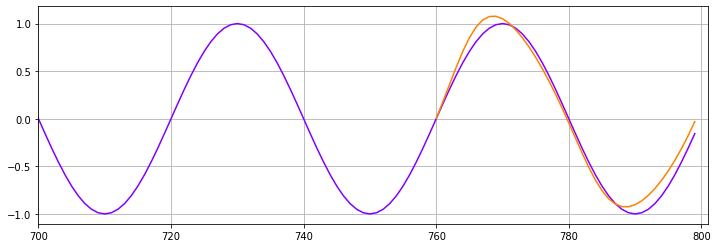

In [13]:
epochs = 10
future = 40

for i in range(epochs):
    
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    preds = train_set[-window_size:].tolist()
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                           torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
        
    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f"Performance on test range: {loss}")
    
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy(),color='#8000ff')
    plt.plot(range(760,800),preds[window_size:],color='#ff8000')
    plt.show()

### 5. Alcohol Sales dataset <a id=13></a>
[back to top](#100)

#### 5.1 Loading and plotting <a id=14></a>

##### 5.1.1 Importing the data

In [14]:
df = pd.read_csv("/kaggle/input/for-simple-exercises-time-series-forecasting/Alcohol_Sales.csv", index_col = 0, parse_dates = True)
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


##### 5.1.2 Dropping the empty rows

In [15]:
df.dropna(inplace=True)
len(df)

325

##### 5.1.3 Plotting the Time Series Data

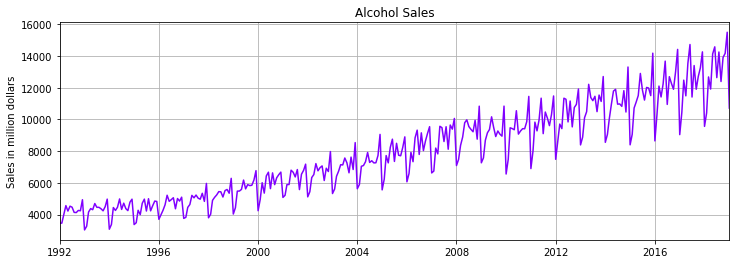

In [16]:
plt.figure(figsize = (12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'],color='#8000ff')
plt.show()

#### 5.2 Prepare and normalize <a id=15></a>

##### 5.2.1 Preparing the data

In [17]:
#extracting the time series values
y = df['S4248SM144NCEN'].values.astype(float) 

#defining a test size
test_size = 12

#create train and test splits
train_set = y[:-test_size]
test_set = y[-test_size:]
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

##### 5.2.2 Normalize the data

In [18]:
from sklearn.preprocessing import MinMaxScaler

# instantiate a scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

##### 5.2.3 Prepare data for LSTM model

In [19]:
# convert train_norm to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# define a window size
window_size = 12
# define a function to create sequence/label tuples
def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# apply input_data to train_norm
train_data = input_data(train_norm, window_size)
len(train_data)

301

##### 5.2.4 Printing the first tuple

In [20]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

#### 5.3 Modelling <a id=16></a>

##### 5.3.1 Model definition

In [21]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

##### 5.3.3 Instantiation, loss and optimizer

In [22]:
torch.manual_seed(42)

# instantiate
model = LSTMnetwork()

# loss
criterion = nn.MSELoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

##### 5.3.4 Training

In [23]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.26208422
Epoch:  2 Loss: 0.34071690
Epoch:  3 Loss: 0.37325260
Epoch:  4 Loss: 0.37144578
Epoch:  5 Loss: 0.32069460
Epoch:  6 Loss: 0.33051443
Epoch:  7 Loss: 0.32643345
Epoch:  8 Loss: 0.32497045
Epoch:  9 Loss: 0.30683771
Epoch: 10 Loss: 0.30106238
Epoch: 11 Loss: 0.29293439
Epoch: 12 Loss: 0.28600523
Epoch: 13 Loss: 0.29466769
Epoch: 14 Loss: 0.27529088
Epoch: 15 Loss: 0.29106244
Epoch: 16 Loss: 0.27637732
Epoch: 17 Loss: 0.28570727
Epoch: 18 Loss: 0.28755152
Epoch: 19 Loss: 0.26827139
Epoch: 20 Loss: 0.26684177
Epoch: 21 Loss: 0.26333189
Epoch: 22 Loss: 0.26537696
Epoch: 23 Loss: 0.25447667
Epoch: 24 Loss: 0.27008417
Epoch: 25 Loss: 0.13406612
Epoch: 26 Loss: 0.00002756
Epoch: 27 Loss: 0.00112184
Epoch: 28 Loss: 0.00000143
Epoch: 29 Loss: 0.00436061
Epoch: 30 Loss: 0.00136413
Epoch: 31 Loss: 0.00003336
Epoch: 32 Loss: 0.00000254
Epoch: 33 Loss: 0.00069296
Epoch: 34 Loss: 0.00001927
Epoch: 35 Loss: 0.00013140
Epoch: 36 Loss: 0.00446211
Epoch: 37 Loss: 0.01253245
E

#### 5.4 Predictions <a id=17></a>

##### 5.4.1 Test set predictions

In [24]:
future = 12

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
preds[window_size:]

[0.254626989364624,
 0.5324987769126892,
 0.5401761531829834,
 0.7740813493728638,
 1.0032850503921509,
 0.4382571876049042,
 0.5605596303939819,
 0.5859595537185669,
 0.6089707612991333,
 0.7689874172210693,
 0.9936566352844238,
 -0.0027425289154052734]

##### 5.4.2 Original test set

In [25]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

##### 5.4.3 Inverting the normalised values

In [26]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10369.94057429],
       [11995.35159555],
       [12040.26040804],
       [13408.48885316],
       [14749.21590227],
       [11444.08541889],
       [12159.49355799],
       [12308.07040948],
       [12442.67446822],
       [13378.69189703],
       [14692.8944881 ],
       [ 8864.45757711]])

##### 5.4.4 Plotting

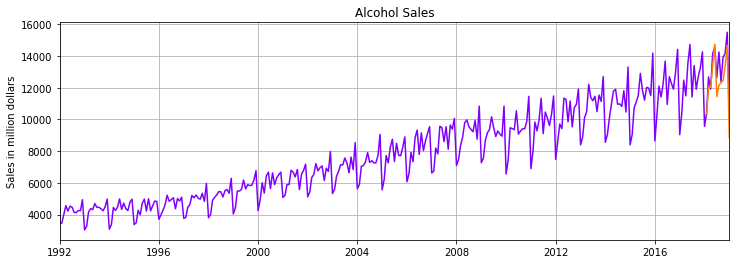

In [27]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'], color='#8000ff')
plt.plot(x,true_predictions, color='#ff8000')
plt.show()

##### 5.5.5 Zooming the test predictions

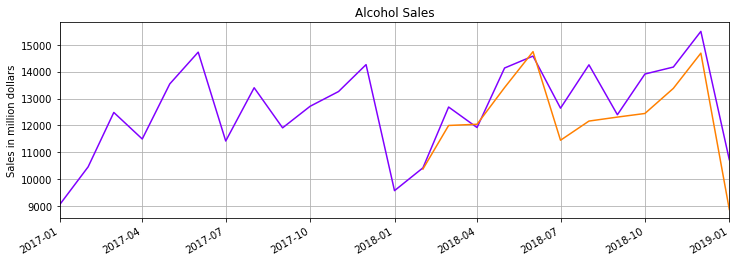

In [28]:
fig = plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

plt.plot(df['S4248SM144NCEN']['2017-01-01':], color='#8000ff')
plt.plot(x,true_predictions, color='#ff8000')
plt.show()

### If you liked the notebook, consider giving an upvote.
[back to top](#100)